In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# 1. Data Visualization

## 1.1 Single Policy Analysis

In [3]:
# Load in the file you want to analyze
# Single Policy experiments:
# 200ScenariosRWSPolicies
# 1000ScenariosBaseCase

# Multiple policy experiments
# 1000ScenariosBaseRfRDikePolicies
# 200Scenarios50Policies

results = utilities.load_results('Outcomes/200Scenarios50Policies.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
# results = results.apply(pd.to_numeric)
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\epa1361_open\final assignment\Outcomes\200Scenarios50Policies.csv


A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                     26.0  308.560347       1.5   0.040640   94.864757   
1                     58.0  113.145318       1.0   0.873360   31.275990   
2                     24.0   92.660114      10.0   0.519441  316.880074   
3                    122.0  304.638762       1.0   0.387266   32.107645   
4                     38.0  106.177684       1.0   0.676617  335.572782   

  A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0       1.5   0.388750  324.442213       1.0   0.273762  ...   
1      10.0   0.239393  166.383414       1.0   0.532549  ...   
2      10.0   0.983236  285.521160       1.5   0.969825  ...   
3       1.0   0.317684  102.327925      10.0   0.427642  ...   
4       1.0   0.400639  218.834865       1.5   0.659950  ...   

   A.3_Dike Investment Costs 2 A.3_Expected Number of Deaths 2  \
0                 4.049237e+08                             0.0   
1                 4.049237e+08                             0.0   
2                 4.049237e+08                             0.0   
3                 4.049237e+08                             0.0   
4                 4.049237e+08                             0.0   

   A.4_Expected Annual Damage 2  A.4_Dike Investment Costs 2  \
0                           0.0                 2.137888e+09   
1                           0.0                 2.137888e+09   
2                           0.0                 2.137888e+09   
3                           0.0                 2.137888e+09   
4                           0.0                 2.137888e+09   

  A.4_Expected Number of Deaths 2  A.5_Expected Annual Damage 2  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   

  A.5_Dike Investment Costs 2 A.5_Expected Number of Deaths 2  \
0                9.712712e+08                             0.0   
1                9.712712e+08                             0.0   
2                9.712712e+08                             0.0   
3                9.712712e+08                             0.0   
4                9.712712e+08                             0.0   

  RfR Total Costs 2  Expected Evacuation Costs 2  
0       377300000.0                          0.0  
1       377300000.0                          0.0  
2       377300000.0                          0.0  
3       377300000.0                          0.0  
4       377300000.0                          0.0  

[5 rows x 103 columns]

In [4]:
results["policy"].unique()

[182, 183, 184, 185, 186, ..., 227, 228, 229, 230, 231]
Length: 50
Categories (50, int64): [182, 183, 184, 185, ..., 228, 229, 230, 231]

In [5]:
# Select the policy name for multiple policy experiments otherwise ignore
# Replace the df (results) as parameter of the functions with policy_df
# policy_df = results[results["policy"] == "RfR only"]

### 1.1.1 Histograms of the outcomes per location and timestep

In [6]:
def histogram_maker(results, outcome, n = 3):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']


    print("Plot " + str(outcome) + "(Histogram)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(10, 3))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            # ax.hist(results[str(place) + "_Expected Annual Damage " + str(step)], color=colors[i])
            ax.hist(results[str(place) + "_" + str(outcome) + " " + str(step)], color=colors[i])
            ax.set_xlim(left = 0)
            ax.set_title(place)

        plt.tight_layout()
        plt.show()

Plot Expected Annual Damage(Histogram)
This is timestep 0


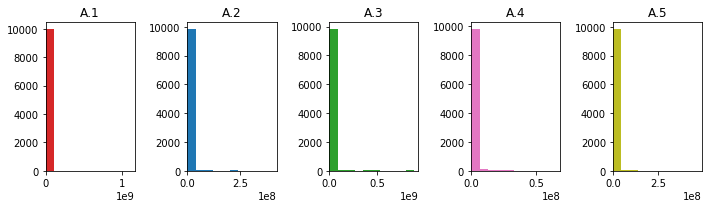

This is timestep 1


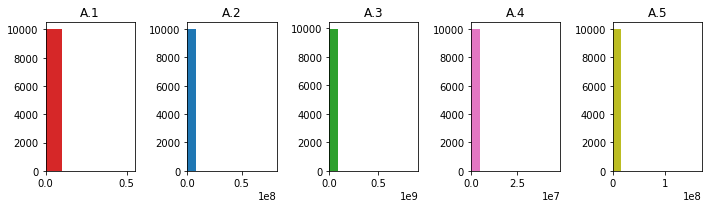

This is timestep 2


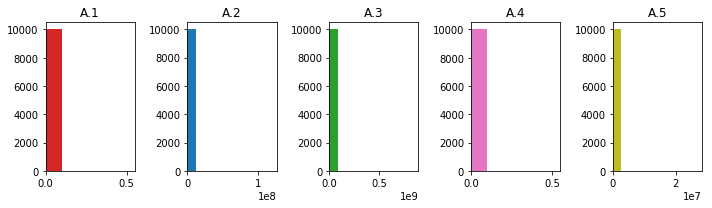

Plot Expected Number of Deaths(Histogram)
This is timestep 0


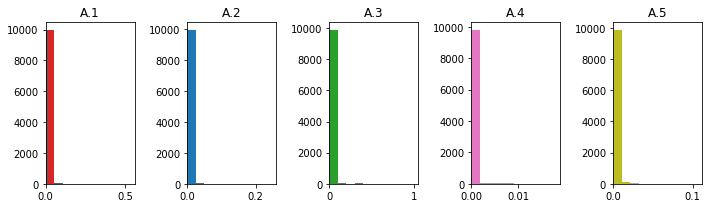

This is timestep 1


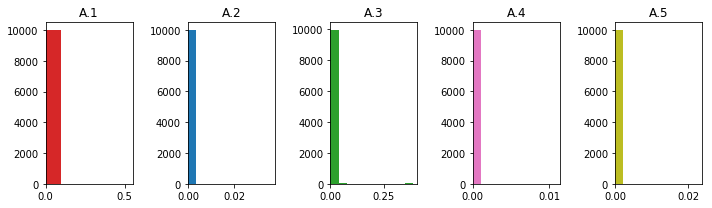

This is timestep 2


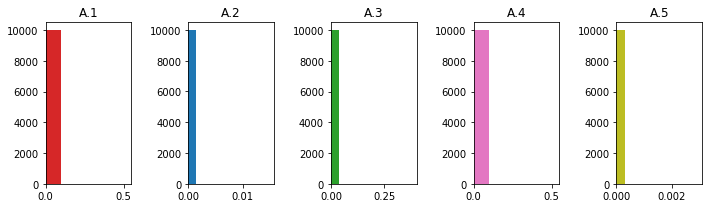

In [7]:
histogram_maker(results, "Expected Annual Damage")
histogram_maker(results, "Expected Number of Deaths")

### 1.1.2 Mean of the outcomes per location and timestep

In [8]:
# Get the mean for all the results across the scenarios to have a quick look at significant locations
mean_outcomes_df = results.iloc[:, 52:].apply(np.mean, axis = 0)

In [9]:
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def mean_outcomes(results):
#     # Get the mean for all the results across the scenarios to have a quick look at significant locations
#     mean_outcomes_df = results.iloc[:, 52:].apply(np.mean, axis = 0)
    
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    outcomes = ["Expected Annual Damage", "Expected Number of Deaths", "Dike Investment Costs", "RfR Total Costs"]
    x = [0, 1, 2]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True)
    axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

    for ax, criteria in zip(axes, outcomes):
        for step in x:
            for place in locations:
                if criteria == "RfR Total Costs":
                    ax.plot(step, mean_outcomes_df[[str(criteria) + " " + str(step)]].values[0], 'ro', c ='y')
                else:
                    if place == "A.1":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="b", label = "A.1")
                    elif place == "A.2":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="r", label = "A.2")
                    elif place == "A.3":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="g", label = "A.3")
                    elif place == "A.4":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="m", label = "A.4")
                    elif place == "A.5":
                        ax.plot(step, mean_outcomes_df[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                                'ro', c="c", label = "A.5")

        ax.set_xlabel("Time Steps")
        ax.set_ylabel(criteria)
        ax.set_title(str(criteria) + " over the locations", y = 1.1)
        legend_without_duplicate_labels(ax)


    plt.tight_layout()
    plt.show()

No handles with labels found to put in legend.


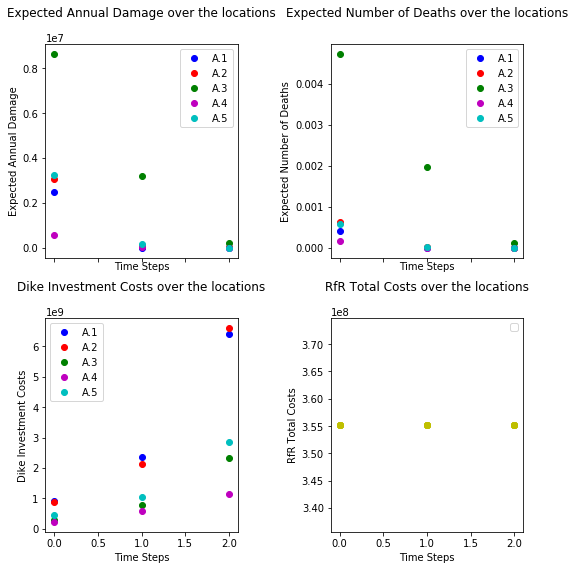

In [10]:
mean_outcomes(results)

## 1.2 Multiple Policies Analysis

In [11]:
results = utilities.load_results('Outcomes/1000ScenariosBaseRfRDikePolicies.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\epa1361_open\final assignment\Outcomes\1000ScenariosBaseRfRDikePolicies.csv


A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                      3.0   30.152160       1.5   0.723535  263.114921   
1                    102.0  234.780753       1.5   0.871943  157.992747   
2                     96.0  178.717816      10.0   0.270734   37.067946   
3                     56.0  130.014723      10.0   0.586453  208.518260   
4                    125.0  162.841266       1.0   0.163939  333.701850   

  A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0       1.5   0.337594  222.510643       1.5   0.773767  ...   
1       1.5   0.100330  339.797187      10.0   0.729555  ...   
2       1.0   0.635735   52.303592      10.0   0.084961  ...   
3      10.0   0.454450   88.082323      10.0   0.225068  ...   
4      10.0   0.264835  205.128637       1.0   0.208254  ...   

   A.3_Dike Investment Costs 2 A.3_Expected Number of Deaths 2  \
0                            0                        0.000000   
1                            0                        0.000000   
2                            0                        0.644546   
3                            0                        0.735927   
4                            0                        0.132648   

   A.4_Expected Annual Damage 2  A.4_Dike Investment Costs 2  \
0                           0.0                            0   
1                           0.0                            0   
2                           0.0                            0   
3                           0.0                            0   
4                           0.0                            0   

  A.4_Expected Number of Deaths 2  A.5_Expected Annual Damage 2  \
0                             0.0                  0.000000e+00   
1                             0.0                  1.866934e+07   
2                             0.0                  0.000000e+00   
3                             0.0                  0.000000e+00   
4                             0.0                  0.000000e+00   

  A.5_Dike Investment Costs 2 A.5_Expected Number of Deaths 2  \
0                           0                        0.000000   
1                           0                        0.015494   
2                           0                        0.000000   
3                           0                        0.000000   
4                           0                        0.000000   

  RfR Total Costs 2  Expected Evacuation Costs 2  
0               0.0                          0.0  
1               0.0                          0.0  
2               0.0                          0.0  
3               0.0                          0.0  
4               0.0                          0.0  

[5 rows x 104 columns]

### 1.2.1 Scatterplot over locations, time steps, and policies

In [12]:
def scatter_maker(results, outcome, n = 3):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    
    print("Plot " + str(outcome) + "(Scatterplot)")
    for step in range(0, n):
        print("This is timestep " + str(step))
        fig, axes = plt.subplots(1, 5, figsize=(15, 4))

        for i, (ax, place) in enumerate(zip(axes.flatten(), locations)):
            plt.sca(ax)
            
            if i != 4:
                ax = sns.scatterplot(x="scenario", y=(str(place) + "_" + str(outcome) + " " + str(step)), hue="policy",
                          data=results, legend = False)
            else:
                ax = sns.scatterplot(x="scenario", y=(str(place) + "_" + str(outcome) + " " + str(step)), hue="policy",
                          data=results)
                ax.legend(loc = 'upper right', bbox_to_anchor=(2, 1), fontsize = 8)

            ax.set_xlim(left = 0)
            ax.set_title(place)

        plt.tight_layout()
        plt.show()
#         plt.legend()

Plot Expected Annual Damage(Scatterplot)
This is timestep 0


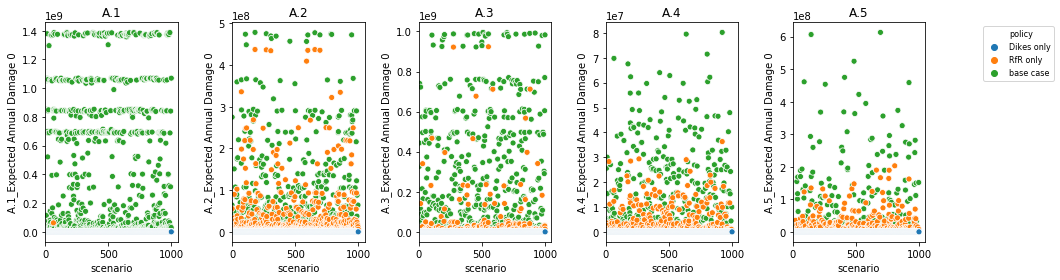

This is timestep 1


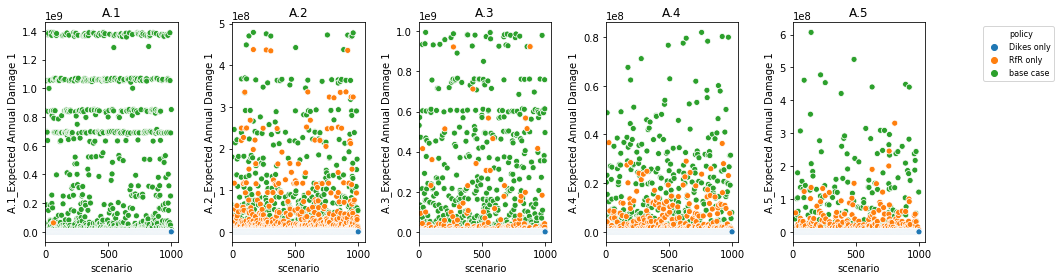

This is timestep 2


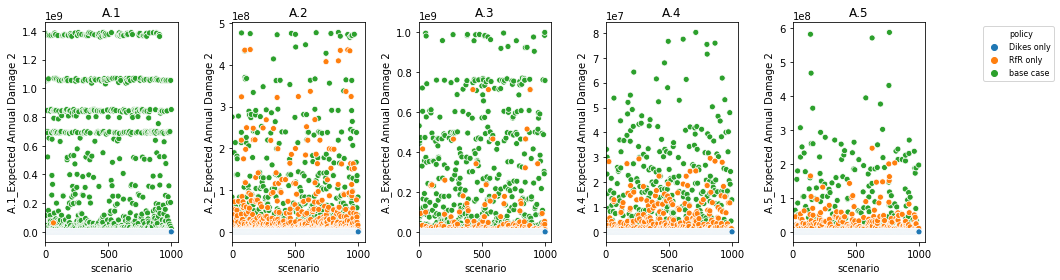

Plot Expected Number of Deaths(Scatterplot)
This is timestep 0


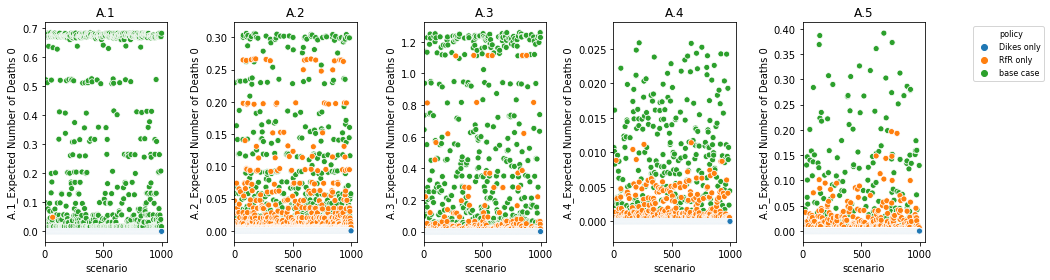

This is timestep 1


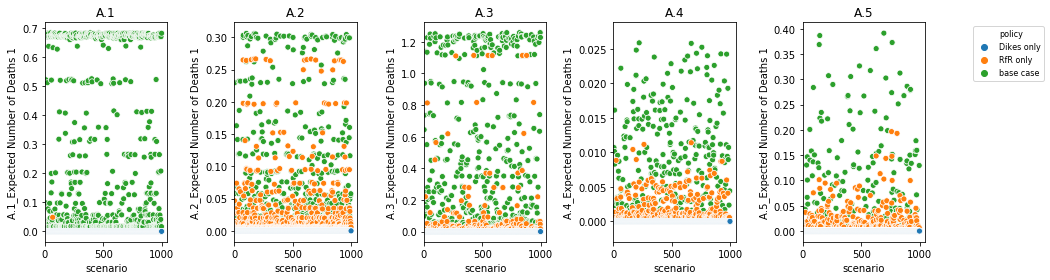

This is timestep 2


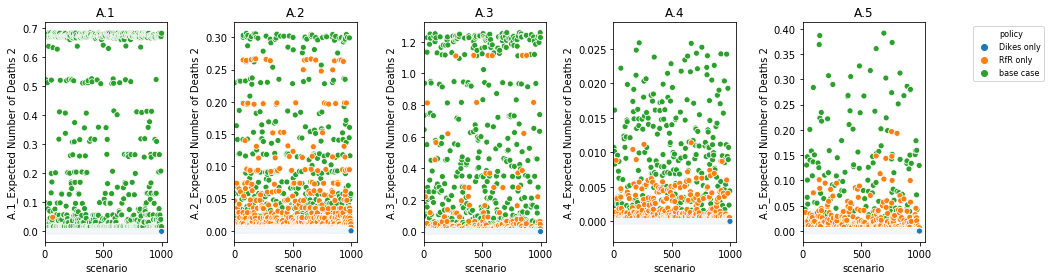

In [13]:
scatter_maker(results, "Expected Annual Damage")
scatter_maker(results, "Expected Number of Deaths")

### 1.2.2 Pairplot

In [14]:
def pairplot_maker(results, location, n = 3):
    list_loc = []

    for i in results.columns:
        if location in i:
            list_loc.append(i)
            
    # TO-DO:        
    # Add other uncertentainties which do not have A.1 in name, like discount rate and flow.. 
    list_loc.append("policy")
    
    sns.pairplot(results[list_loc], hue='policy',  vars=results[list_loc].iloc[:, 6:-1].keys(), )
    plt.tight_layout()
    plt.show()

C:\Users\newbi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\newbi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


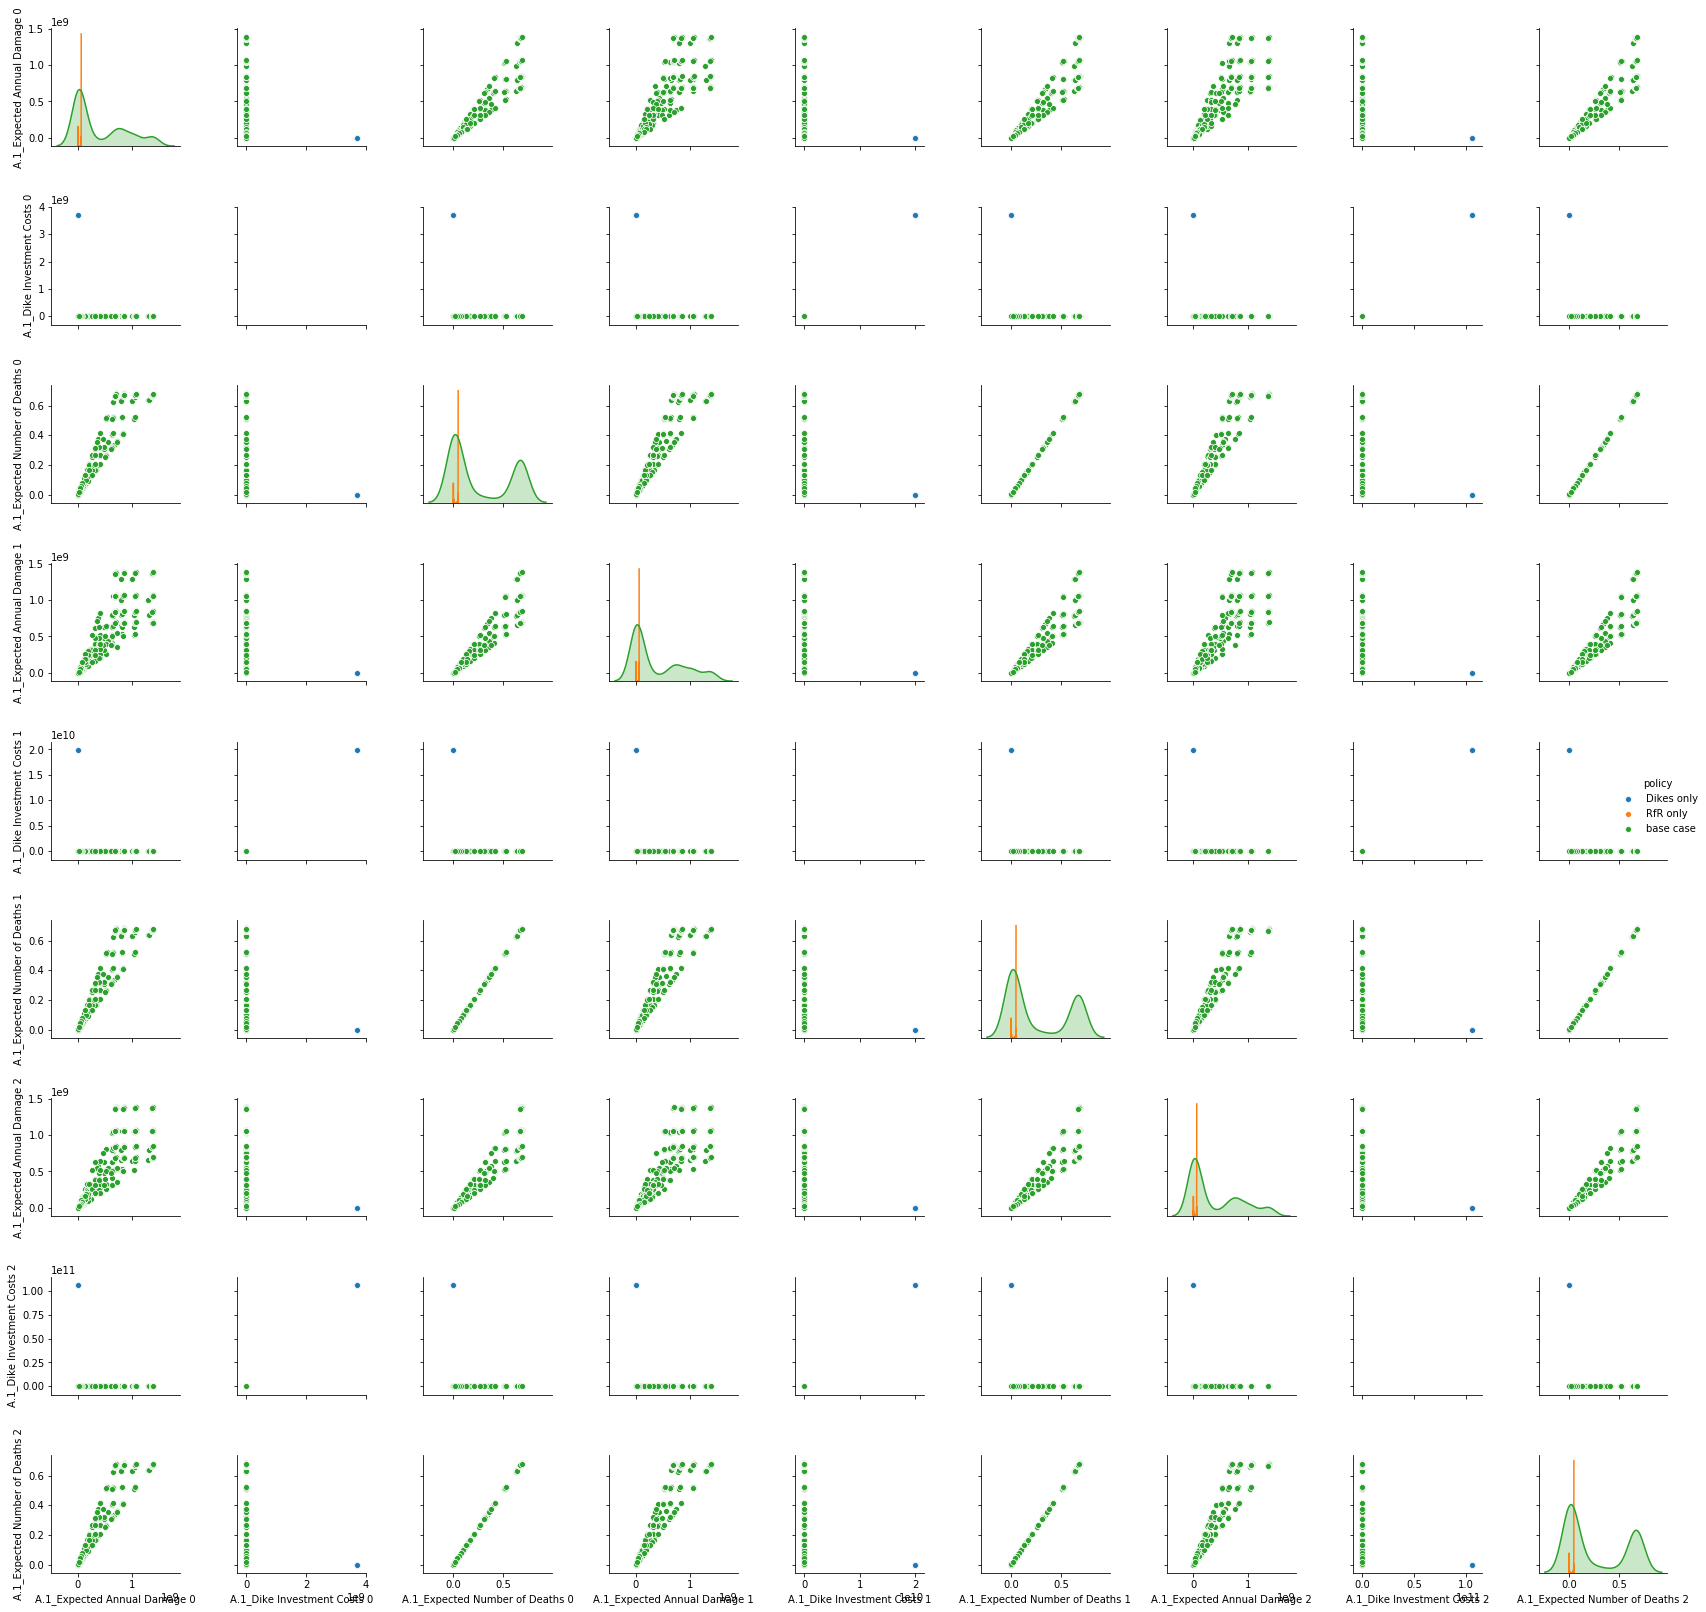

In [15]:
pairplot_maker(results, "A.1")
# pairplot_maker(results, "A.2")
# pairplot_maker(results, "A.3")
# pairplot_maker(results, "A.4")
# pairplot_maker(results, "A.5")